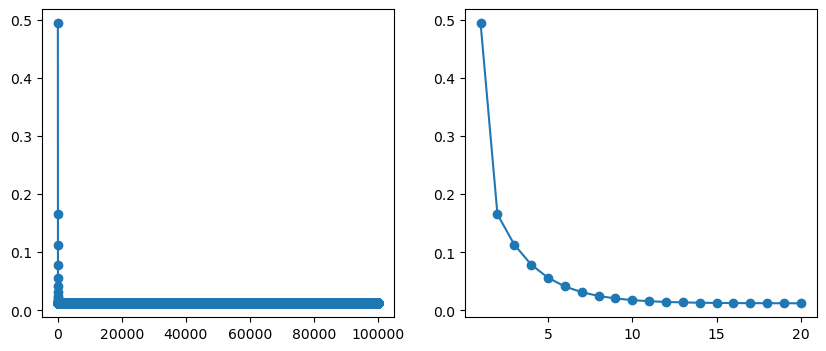

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd


# Adaline (Adaptive Linear Neuron) 모델 클래스 정의
class AdalineGD:
    # 모델 초기화
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta  # 학습률 (step size)
        self.n_iter = n_iter  # 훈련할 반복 횟수
        self.random_state = random_state  # 랜덤 시드를 설정하여 재현 가능하도록 설정
    
    # 훈련 데이터를 기반으로 모델 학습
    # method self를 주는 이유 : 맴버 변수 생성하거나 접근하게 하려고 준다
    def fit(self, X, y): # X : 학습 데이터, y : 원래 답
        rgen = np.random.RandomState(self.random_state)  # 주어진 시드로 랜덤 넘버 생성기 초기화
        # 가중치(w_)를 작은 랜덤 값으로 초기화
        self.w_ = rgen.normal(
            loc=0.0 # 평균
            , scale=0.01 # 표준편차
            , size=X.shape[1]
        )  # 작은 값으로 초기화
        self.b_ = np.float_(0.)  # 바이어스(bias)는 0으로 초기화
        self.losses_ = []  # 각 반복에서의 손실값을 저장할 리스트
        
        # 주어진 반복 횟수만큼 Gradient Descent 수행
        for i in range(self.n_iter):
            # 입력값 X와 가중치 w_의 내적 + 바이어스를 계산하여 순 입력 값 구하기
            net_input = self.net_input(X)
            # 순 입력 값에 활성화 함수 적용 (Adaline은 선형 활성화 함수)
            output = self.activation(net_input)
            # 실제 값(y)와 예측 값(output)의 오차 계산
            errors = (y - output)
            # 가중치 업데이트 (오차에 대한 기울기)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            # 바이어스 업데이트 (오차 평균에 대한 기울기)
            self.b_ += self.eta * 2.0 * errors.mean()
            # 손실값 계산 (평균 제곱 오차)
            loss = (errors ** 2).mean()
            self.losses_.append(loss)  # 손실값을 리스트에 저장
        
        return self  # 훈련된 모델 반환
    
    # 순 입력 계산 (X * 가중치 + 바이어스)
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    # 활성화 함수 (Adaline에서는 항등 함수, 즉 입력 그대로 반환)
    def activation(self, X):
        return X
    
    # 모델을 이용한 예측 함수
    def predict(self, X):
        # 예측값이 0 이상이면 1, 아니면 -1로 반환
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'  # Iris dataset URL

# Load the data into a DataFrame
df = pd.read_csv(s, header=None, encoding='utf-8')

# Create the target variable
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)  # Convert labels to binary (0 or 1)

# Extract the features (sepal length and petal length)
X = df.iloc[0:100, [0, 2]].values

# Standardize the features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()  # Standardize the first feature (sepal length)
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()  # Standardize the second feature (petal length)


ada_gd =AdalineGD(n_iter=20,eta=0.5)
ada_gd.fit(X_std,y)


# 오차 시각화
fig, ax = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(10, 4)
)

ada1 = AdalineGD(n_iter=100000, eta=0.5).fit(X_std, y) 
ax[0].plot(
    range(1, len(ada1.losses_) + 1),
    ada1.losses_,
    marker='o'
)


ada2 = AdalineGD(n_iter=20, eta=0.5).fit(X_std, y) # 표준화 한 데이터 
ax[1].plot(
    range(1, len(ada2.losses_) + 1),
    ada2.losses_,
    marker='o'
)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd

class AdalineSGD:
    # 3개의 boolean type : 에포크별 가중치 초기화 여부, 섞어야하고, 시드 여부
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        '''
        Adaline(Adaptive Linear Neuron) 모델을 위한 초기화 함수
        
        Parameters:
        eta : 학습률 (learning rate), 가중치 업데이트의 크기
        n_iter : 학습을 위한 에포크 수 (반복 횟수)
        shuffle : 데이터를 섞을지 여부
        random_state : 랜덤 시드를 고정하려면 값 설정 (None이면 랜덤)
        '''
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False  # 가중치 초기화 여부
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        '''
        주어진 훈련 데이터 X, 타겟 값 y에 대해 학습
        
        Parameters:
        X : 훈련 데이터 (특징 벡터)
        y : 타겟 값 (실제 레이블)
        
        Returns:
        self : 학습된 모델 반환
        '''
        self._initialize_weights(X.shape[1])  # 가중치 초기화
        self.losses_ = []  # 에포크별 손실을 기록할 리스트
        
        for i in range(self.n_iter):
            # 데이터 섞기 (shuffle이 True일 경우)
            if self.shuffle:
                X, y = self._shuffle(X, y)
            
            losses = []  # 각 샘플별 손실을 기록할 리스트
            # 샘플 하나씩 학습 (온라인 학습 방식)
            for xi, target in zip(X, y):  # xi, target은 하나의 샘플과 그에 해당하는 레이블
                losses.append(self._update_weights(xi, target))  # 가중치 업데이트하고 손실 계산
            
            avg_loss = np.mean(losses)  # 평균 손실 계산
            self.losses_.append(avg_loss)  # 에포크별 손실 기록
        
        return self

    def partial_fit(self, X, y):
        '''
        가중치를 초기화하지 않고 주어진 데이터로 추가 학습
        
        Parameters:
        X : 훈련 데이터 (특징 벡터)
        y : 타겟 값 (실제 레이블)
        
        Returns:
        self : 학습된 모델 반환
        '''
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])  # 초기화되지 않았다면 가중치 초기화
        
        if y.ravel().shape[0] > 1:  # 부분 데이터로 학습, ravel 함수는 주로 NumPy 라이브러리에서 사용되는 함수로, 다차원 배열을 1차원 배열로 평탄화(flatten)하는 데 사용
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:  # 전체 데이터에 학습
            self._update_weights(X, y)
        
        return self

    def _shuffle(self, X, y):
        '''
        훈련 데이터를 무작위로 섞기
        
        Parameters:
        X : 훈련 데이터 (특징 벡터)
        y : 타겟 값 (실제 레이블)
        
        Returns:
        X, y : 섞인 데이터와 레이블 반환
        '''
        idx = self.rgen.permutation(len(y))  # 무작위 순서 생성
        return X[idx], y[idx]  # 섞은 데이터와 레이블 반환

    def _initialize_weights(self, feature_count):
        '''가중치를 랜덤한 작은 값으로 초기화'''
        self.rgen = np.random.RandomState(self.random_state)  # 난수 생성기 초기화 (시드 설정), random_state=None여서 난수 생성 값 고정 x
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=feature_count)  # 평균 0, 표준편차 0.01로 가중치 초기화
        self.b_ = np.float_(0,)  # 바이어스 초기화
        self.w_initialized = True  # 가중치가 초기화되었음을 표시

    def _update_weights(self, xi, target):
        '''Adaline 학습 규칙을 적용하여 가중치 업데이트'''
        output = self.activation(self.net_input(xi))  # 예측값 계산
        error = (target - output)  # 오차 계산
        self.w_ += self.eta * 2.0 * xi * (error)  # 가중치 업데이트
        self.b_ += self.eta * 2.0 * error  # 바이어스 업데이트
        loss = error**2  # 손실 계산 (제곱 오차)
        return loss  # 손실 값 반환

    def net_input(self, X):
        '''입력 값 계산 (가중치와 특성의 선형 결합)'''
        return np.dot(X, self.w_) + self.b_  # X와 가중치 w_의 내적, 바이어스 b_ 추가

    def activation(self, X):
        '''활성화 함수 (Adaline에서는 단순 선형 함수)'''
        return X  # 이 경우 활성화 함수는 그대로 반환 (선형 활성화)

    def predict(self, X):
        '''입력 X에 대해 예측된 클래스 반환'''
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)  # 활성화 값이 0.5 이상이면 1, 그 이하는 0으로 예측


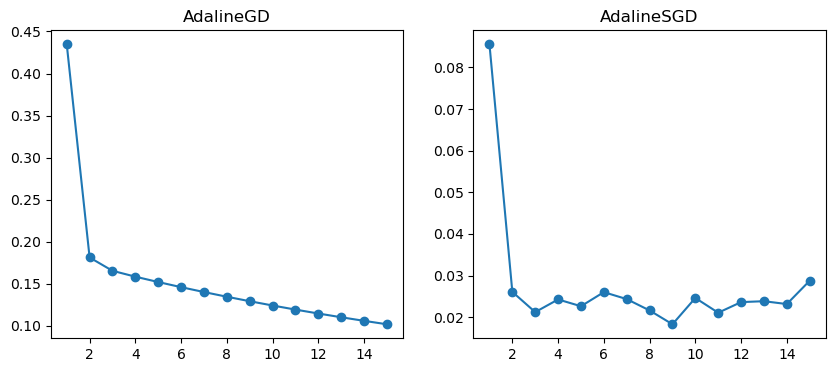

In [21]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'  # Iris dataset URL

# Load the data into a DataFrame
df = pd.read_csv(s, header=None, encoding='utf-8')

# Create the target variable
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)  # Convert labels to binary (0 or 1)

# Extract the features (sepal length and petal length)
X = df.iloc[0:100, [0, 2]].values

# Standardize the features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()  # Standardize the first feature (sepal length)
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()  # Standardize the second feature (petal length)


# Adaline (Adaptive Linear Neuron) 모델 클래스 정의
class AdalineGD:
    # 모델 초기화
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta  # 학습률 (step size)
        self.n_iter = n_iter  # 훈련할 반복 횟수
        self.random_state = random_state  # 랜덤 시드를 설정하여 재현 가능하도록 설정
    
    # 훈련 데이터를 기반으로 모델 학습
    # method self를 주는 이유 : 맴버 변수 생성하거나 접근하게 하려고 준다
    def fit(self, X, y): # X : 학습 데이터, y : 원래 답
        rgen = np.random.RandomState(self.random_state)  # 주어진 시드로 랜덤 넘버 생성기 초기화
        # 가중치(w_)를 작은 랜덤 값으로 초기화
        self.w_ = rgen.normal(
            loc=0.0 # 평균
            , scale=0.01 # 표준편차
            , size=X.shape[1]
        )  # 작은 값으로 초기화
        self.b_ = np.float_(0.)  # 바이어스(bias)는 0으로 초기화
        self.losses_ = []  # 각 반복에서의 손실값을 저장할 리스트
        
        # 주어진 반복 횟수만큼 Gradient Descent 수행
        for i in range(self.n_iter):
            # 입력값 X와 가중치 w_의 내적 + 바이어스를 계산하여 순 입력 값 구하기
            net_input = self.net_input(X)
            # 순 입력 값에 활성화 함수 적용 (Adaline은 선형 활성화 함수)
            output = self.activation(net_input)
            # 실제 값(y)와 예측 값(output)의 오차 계산
            errors = (y - output)
            # 가중치 업데이트 (오차에 대한 기울기)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            # 바이어스 업데이트 (오차 평균에 대한 기울기)
            self.b_ += self.eta * 2.0 * errors.mean()
            # 손실값 계산 (평균 제곱 오차)
            loss = (errors ** 2).mean()
            self.losses_.append(loss)  # 손실값을 리스트에 저장
        
        return self  # 훈련된 모델 반환
    
    # 순 입력 계산 (X * 가중치 + 바이어스)
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    # 활성화 함수 (Adaline에서는 항등 함수, 즉 입력 그대로 반환)
    def activation(self, X):
        return X
    
    # 모델을 이용한 예측 함수
    def predict(self, X):
        # 예측값이 0 이상이면 1, 아니면 -1로 반환
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

class AdalineSGD:
    # 3개의 boolean type : 에포크별 가중치 초기화 여부, 섞어야하고, 시드 여부
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        '''
        Adaline(Adaptive Linear Neuron) 모델을 위한 초기화 함수
        
        Parameters:
        eta : 학습률 (learning rate), 가중치 업데이트의 크기
        n_iter : 학습을 위한 에포크 수 (반복 횟수)
        shuffle : 데이터를 섞을지 여부
        random_state : 랜덤 시드를 고정하려면 값 설정 (None이면 랜덤)
        '''
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False  # 가중치 초기화 여부
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        '''
        주어진 훈련 데이터 X, 타겟 값 y에 대해 학습
        
        Parameters:
        X : 훈련 데이터 (특징 벡터)
        y : 타겟 값 (실제 레이블)
        
        Returns:
        self : 학습된 모델 반환
        '''
        self._initialize_weights(X.shape[1])  # 가중치 초기화
        self.losses_ = []  # 에포크별 손실을 기록할 리스트
        
        for i in range(self.n_iter):
            # 데이터 섞기 (shuffle이 True일 경우)
            if self.shuffle:
                X, y = self._shuffle(X, y)
            
            losses = []  # 각 샘플별 손실을 기록할 리스트
            # 샘플 하나씩 학습 (온라인 학습 방식)
            for xi, target in zip(X, y):  # xi, target은 하나의 샘플과 그에 해당하는 레이블
                losses.append(self._update_weights(xi, target))  # 가중치 업데이트하고 손실 계산
            
            avg_loss = np.mean(losses)  # 평균 손실 계산
            self.losses_.append(avg_loss)  # 에포크별 손실 기록
        
        return self

    def partial_fit(self, X, y):
        '''
        가중치를 초기화하지 않고 주어진 데이터로 추가 학습
        
        Parameters:
        X : 훈련 데이터 (특징 벡터)
        y : 타겟 값 (실제 레이블)
        
        Returns:
        self : 학습된 모델 반환
        '''
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])  # 초기화되지 않았다면 가중치 초기화
        
        if y.ravel().shape[0] > 1:  # 부분 데이터로 학습, ravel 함수는 주로 NumPy 라이브러리에서 사용되는 함수로, 다차원 배열을 1차원 배열로 평탄화(flatten)하는 데 사용
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:  # 전체 데이터에 학습
            self._update_weights(X, y)
        
        return self

    def _shuffle(self, X, y):
        '''
        훈련 데이터를 무작위로 섞기
        
        Parameters:
        X : 훈련 데이터 (특징 벡터)
        y : 타겟 값 (실제 레이블)
        
        Returns:
        X, y : 섞인 데이터와 레이블 반환
        '''
        idx = self.rgen.permutation(len(y))  # 무작위 순서 생성
        return X[idx], y[idx]  # 섞은 데이터와 레이블 반환

    def _initialize_weights(self, feature_count):
        '''가중치를 랜덤한 작은 값으로 초기화'''
        self.rgen = np.random.RandomState(self.random_state)  # 난수 생성기 초기화 (시드 설정), random_state=None여서 난수 생성 값 고정 x
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=feature_count)  # 평균 0, 표준편차 0.01로 가중치 초기화
        self.b_ = np.float_(0,)  # 바이어스 초기화
        self.w_initialized = True  # 가중치가 초기화되었음을 표시

    def _update_weights(self, xi, target):
        '''Adaline 학습 규칙을 적용하여 가중치 업데이트'''
        output = self.activation(self.net_input(xi))  # 예측값 계산
        error = (target - output)  # 오차 계산
        self.w_ += self.eta * 2.0 * xi * (error)  # 가중치 업데이트
        self.b_ += self.eta * 2.0 * error  # 바이어스 업데이트
        loss = error**2  # 손실 계산 (제곱 오차)
        return loss  # 손실 값 반환

    def net_input(self, X):
        '''입력 값 계산 (가중치와 특성의 선형 결합)'''
        return np.dot(X, self.w_) + self.b_  # X와 가중치 w_의 내적, 바이어스 b_ 추가

    def activation(self, X):
        '''활성화 함수 (Adaline에서는 단순 선형 함수)'''
        return X  # 이 경우 활성화 함수는 그대로 반환 (선형 활성화)

    def predict(self, X):
        '''입력 X에 대해 예측된 클래스 반환'''
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)  # 활성화 값이 0.5 이상이면 1, 그 이하는 0으로 예측


# 오차 시각화
fig, ax = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(10, 4)
)

ada1 = AdalineGD(n_iter=15, eta=0.01).fit(X, y) 
ax[0].plot(
    range(1, len(ada1.losses_) + 1),
    ada1.losses_,
    marker='o'
)
ax[0].set_title('AdalineGD')


ada2 = AdalineSGD(n_iter=15, eta=0.01).fit(X, y) 
ax[1].plot(
    range(1, len(ada2.losses_) + 1),
    ada2.losses_,
    marker='o'
)
ax[1].set_title('AdalineSGD')
plt.show()